![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de popularidad en canción

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de popularidad en canción".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad-2025-12-prediccion-popularidad-en-cancion).

## Datos para la predicción de popularidad en cancion

En este proyecto se usará el conjunto de datos de datos de popularidad en canciones, donde cada observación representa una canción y se tienen variables como: duración de la canción, acusticidad y tempo, entre otras. El objetivo es predecir qué tan popular es la canción. Para más detalles puede visitar el siguiente enlace: [datos](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

In [3]:
# Carga de datos 
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv', index_col=0)

### 1. Preprocesamiento de datos

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,0,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,...,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22
1,1,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,...,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22
2,2,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,...,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37
3,3,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,...,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,4,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,...,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27


In [5]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        79800 non-null  int64  
 1   track_id          79800 non-null  object 
 2   artists           79800 non-null  object 
 3   album_name        79800 non-null  object 
 4   track_name        79800 non-null  object 
 5   duration_ms       79800 non-null  int64  
 6   explicit          79800 non-null  bool   
 7   danceability      79800 non-null  float64
 8   energy            79800 non-null  float64
 9   key               79800 non-null  int64  
 10  loudness          79800 non-null  float64
 11  mode              79800 non-null  int64  
 12  speechiness       79800 non-null  float64
 13  acousticness      79800 non-null  float64
 14  instrumentalness  79800 non-null  float64
 15  liveness          79800 non-null  float64
 16  valence           79800 non-null  float6

In [6]:
# Revisar duplicados
dataTraining.duplicated().sum()

0

In [7]:
# Revisar nulos
dataTraining.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
popularity          0
dtype: int64

In [8]:
# Estadísticas generales
dataTraining.describe() 

,Unnamed: 0,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,79800.000000,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,39899.500000,2.279022e+05,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076559,3.902556,33.265301
std,23036.420078,1.050599e+05,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941937,0.434284,22.330871
min,0.000000,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19949.750000,1.744360e+05,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081250,4.000000,17.000000
50%,39899.500000,2.128130e+05,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009000,4.000000,35.000000
75%,59849.250000,2.614260e+05,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054000,4.000000,50.000000
max,79799.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,100.000000


<Axes: xlabel='popularity', ylabel='Count'>

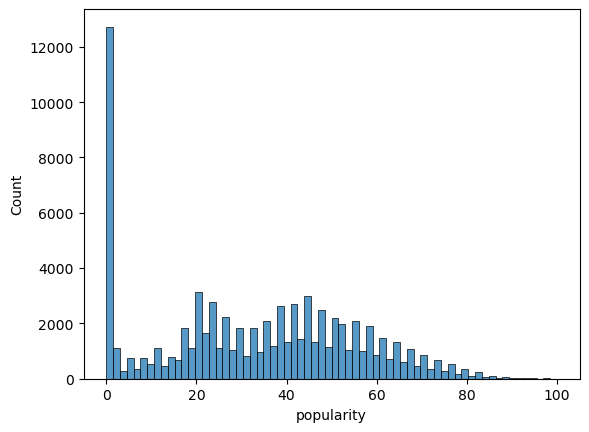

In [9]:
# Distribución de la variable objetivo
sns.histplot(dataTraining['popularity'])

<Axes: >

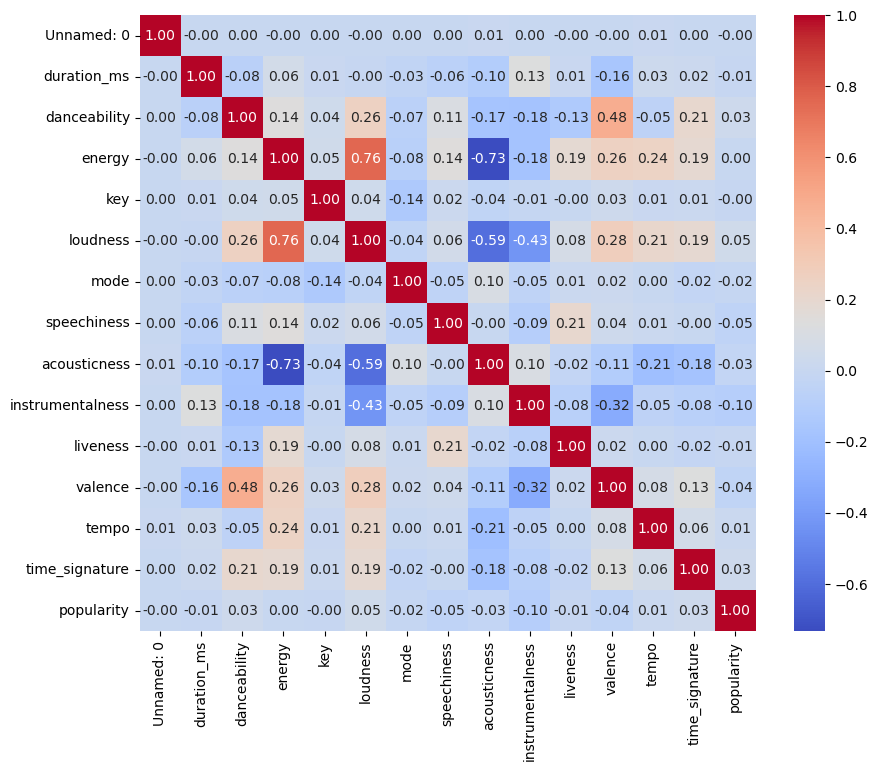

In [10]:
corr = dataTraining.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", square=True)

In [11]:
# Definir las columnas
numerical_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_cols = ['artists', 'album_name', 'key', 'mode', 'time_signature']
target_col = 'popularity'

In [12]:
# Unir ambos para enriquecer
full_data_without_target = pd.concat((dataTraining.drop(columns=target_col), dataTesting), axis=0)

# Artist features
artists_means = full_data_without_target.groupby('artists')[numerical_cols].mean().add_suffix('_artists_mean').reset_index()
artists_stds = full_data_without_target.groupby('artists')[numerical_cols].std().fillna(0).add_suffix('_artists_std').reset_index()
artists_counts = full_data_without_target.groupby('artists').size().reset_index(name='artists_count')
artists_features = artists_means.merge(artists_stds, on='artists').merge(artists_counts, on='artists')

# Album features
album_means = full_data_without_target.groupby('album_name')[numerical_cols].mean().add_suffix('_album_name_mean').reset_index()
album_stds = full_data_without_target.groupby('album_name')[numerical_cols].std().fillna(0).add_suffix('_album_name_std').reset_index()
album_counts = full_data_without_target.groupby('album_name').size().reset_index(name='album_name_count')
album_features = album_means.merge(album_stds, on='album_name').merge(album_counts, on='album_name')

# Enriquecer dataset
enriched_data = full_data_without_target.merge(artists_features, on='artists', how='left')
enriched_data = enriched_data.merge(album_features, on='album_name', how='left')

In [13]:
new_train_data = pd.concat([enriched_data.iloc[:dataTraining.shape[0]].reset_index(drop=True),
                            dataTraining[target_col].reset_index(drop=True)], axis=1)
new_test_data = enriched_data.iloc[dataTraining.shape[0]:].reset_index(drop=True)

In [14]:
# Separar train y validación
X = new_train_data.drop(columns=target_col)
y = new_train_data[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento: fit solo en X_train
scaler = StandardScaler()
encoder = TargetEncoder(cols=categorical_cols, smoothing=0.0)

scaler.fit(X_train[numerical_cols])
encoder.fit(X_train[categorical_cols], y_train)

# Transformar train, val y test
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
new_test_data[numerical_cols] = scaler.transform(new_test_data[numerical_cols])

X_train[categorical_cols] = encoder.transform(X_train[categorical_cols])
X_val[categorical_cols] = encoder.transform(X_val[categorical_cols])
new_test_data[categorical_cols] = encoder.transform(new_test_data[categorical_cols])

In [15]:
cols_to_drop = ['track_id', 'track_name', 'track_genre']

X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)

In [16]:
catboost_params = {
    'iterations': 10_000,
    'learning_rate': 0.1,
    'depth': 8,
    'objective': 'RMSE',
    'thread_count': 4,
    'silent': True,
}

# Entrenar el modelo
bst = CatBoostRegressor(**catboost_params)
bst.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

# Evaluar en validación
y_val_pred = bst.predict(X_val)

In [17]:
# Predicciones en entrenamiento
y_train_pred = bst.predict(X_train)

# Métricas en entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("\nMétricas en TRAIN")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"R²: {r2_train:.4f}")


Métricas en TRAIN
RMSE: 1.5458
MAE: 1.0018
R²: 0.9952


In [18]:
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred)) 

mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("\nMétricas en VALIDATION")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Métricas en VALIDATION
RMSE: 9.6584
MAE: 6.3379
R²: 0.8113


In [19]:
# Visualización datos de test
dataTesting.head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


In [20]:
# Eliminar columnas innecesarias en el set de test 
new_test_data_final = new_test_data.drop(columns=cols_to_drop)

# Predecir sobre el set de test con el modelo entrenado
y_pred_test = bst.predict(new_test_data_final)

In [21]:
# Clipping para mantener en el rango [0, 100]
y_pred = np.clip(y_pred_test, 0, 100)

# Crear DataFrame para submission
y_pred_df = pd.DataFrame(y_pred, index=dataTesting.index, columns=['Popularity'])
y_pred_df.to_csv('test_submission_cat2.csv', index_label='ID')

# Vista previa
print(y_pred_df.head())

   Popularity
0   46.504937
1   14.233283
2    2.692873
3    0.000000
4   34.997721
